<a href="https://colab.research.google.com/github/LucasPaschini/php/blob/main/Active_Learning_Suggestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training section

In [ ]:
from ase.io import read
import glob
import time
from quasigraph import QuasiGraph
from collections import Counter
from dscribe.descriptors import MBTR
import numpy as np
import pandas as pd

ModuleNotFoundError: No module named 'ase'

### Reading XYZ files

In [ ]:
# Path to the subdirectory
subdirectory = 'M55_XYZs/'

# Pattern to match all .xyz files
file_pattern = subdirectory + '*.xyz'

# Find all .xyz files in the subdirectory
xyz_files = glob.glob(file_pattern)
xyz_files.sort()
#print(xyz_files)

structures = []

# Iterate over the list of file paths
for file_path in xyz_files:
    # Read the file content
    content = read(file_path)
    structures.append(content)
    #print(content)
    #time.sleep(0.01)


### Make a list of all the atomic symbols for each structure

In [ ]:
species = list()
for structure in structures:
    species.append(structure.get_chemical_symbols())
#print(species)

In [ ]:
columns = []
for i in range(0,56):
    columns.append(i)
    i += 1

df_compositions = pd.DataFrame(species, columns=columns)
#print(df_compositions)
df_deltaG = pd.read_csv("M55H.csv", delimiter=",")
df_compositions_deltaG = pd.merge(df_compositions, df_deltaG['dG'], right_index=True, left_index=True)
df_compositions_deltaG.to_csv('M55_Composition_deltaG.csv', index=False)


### Set original coordinates

In [ ]:
original_coordinates = [
[ 7.503076,  7.500287,  7.500527],
[ 7.501496,  7.499433, 10.519347],
[10.201966,  7.499429,  8.850971],
[ 8.335428, 10.068041,  8.850214],
[ 5.318077,  9.087307,  8.851202],
[ 5.318866,  5.911266,  8.851139],
[ 8.336276,  4.930687,  8.850644],
[ 9.685200,  5.911761,  6.150445],
[ 9.685521,  9.087984,  6.148732],
[ 6.666817, 10.068366,  6.149321],
[ 4.801795,  7.500758,  6.149909],
[ 6.666785,  4.932150,  6.150026],
[ 7.501420,  7.499782,  4.481116],
[ 7.500925,  7.498200, 13.500912],
[12.867908,  7.499579, 10.183295],
[ 9.158612, 12.604167, 10.182569],
[ 3.159135, 10.653242, 10.182372],
[ 3.159425,  4.345405, 10.183346],
[ 9.158834,  2.394463, 10.183389],
[11.840844,  4.345272,  4.816278],
[11.840496, 10.654892,  4.815631],
[ 5.840863, 12.604191,  4.816097],
[ 2.133747,  7.499933,  4.816731],
[ 5.840686,  2.395788,  4.817810],
[ 7.497854,  7.500683,  1.499006],
[10.246385,  7.498014, 11.942265],
[ 8.349436, 10.110104, 11.941822],
[ 5.282997,  9.113116, 11.942940],
[ 5.281426,  5.885068, 11.943276],
[ 8.348798,  4.888329, 11.942536],
[11.093924, 10.109976, 10.244917],
[11.093603,  4.888408, 10.245791],
[12.464710,  5.885214,  7.499452],
[12.464716,  9.113910,  7.499517],
[ 6.128712, 11.724833, 10.244819],
[10.567471, 11.724218,  7.499633],
[ 7.499089, 12.720750,  7.499842],
[ 3.061130,  7.498289, 10.246121],
[ 4.430662, 11.723297,  7.499848],
[ 2.536723,  9.111434,  7.501259],
[ 6.128281,  3.274767, 10.244911],
[ 2.537708,  5.888022,  7.500629],
[ 4.432596,  3.276156,  7.498634],
[10.569375,  3.275952,  7.501273],
[ 7.500610,  2.279334,  7.501010],
[11.939403,  7.498910,  4.753132],
[ 8.873093,  3.274998,  4.755841],
[ 9.719744,  5.886501,  3.057833],
[ 8.871855, 11.725941,  4.754606],
[ 9.718989,  9.113611,  3.056842],
[ 3.907536, 10.110258,  4.754579],
[ 6.649566, 10.110144,  3.057685],
[ 3.908735,  4.888195,  4.753890],
[ 4.755339,  7.500967,  3.057870],
[ 6.650073,  4.889215,  3.058556],
[ 7.500925,  7.498200, 15.160912],
]

### Generate new XYZ

In [ ]:
structure_number = 0
for structure in species:
    # Fixed filename formatting with f-string
    filename = f'temp_xyz/structure_to_train_{structure_number:04}.xyz'
    with open(filename, 'w') as file:
        i = 0
        file.write('56\n')
        file.write('\n')
        for atom in structure:
            file.write(f'{atom} {original_coordinates[i][0]} {original_coordinates[i][1]} {original_coordinates[i][2]}\n')
            i += 1
    structure_number += 1

### Generate SOAP Features

In [ ]:
from dscribe.descriptors import SOAP
import pandas as pd

structures = []

for idx in range(0,741):
    #print(f'SOAPing nanoparticle: temp_xyz/structure_to_train_{idx:04}.xyz')
    atoms = read(f'temp_xyz/structure_to_train_{idx:04}.xyz')
    structures.append(atoms)

species = set()
for structure in structures:
    species.update(structure.get_chemical_symbols())
print(species)

#print(help(SOAP))
soap = SOAP(
    species=species,
    periodic=False,
    r_cut=12.0,
    n_max=8,
    l_max=8,
    average="inner",
    sparse=False
)

feature_vectors = soap.create(structures, n_jobs=4)

print("Feature Vector", len(feature_vectors))
print(type(feature_vectors))
print('Number of features', soap.get_number_of_features())
soap_features = pd.DataFrame(feature_vectors)

{'H', 'Pd', 'Au', 'Cu', 'Pt', 'Ag'}
Feature Vector 741
<class 'numpy.ndarray'>
Number of features 10584


### Get MBTR features

In [ ]:
mbtr = MBTR(
    species=species,
    geometry={"function": "inverse_distance"},
    grid={"min": 0, "max": 1, "n": 100, "sigma": 0.05},
    weighting={"function": "exp", "scale": 0.5, "threshold": 1e-3},
    periodic=False,
    normalization="l2",
)

mbtr_features = mbtr.create(structures)

print("Feature Vector", len(mbtr_features))
print(type(mbtr_features))

mbtr_features_df = pd.DataFrame(mbtr_features)

Feature Vector 741
<class 'numpy.ndarray'>


### Run QuasiGraph

In [ ]:
qgrs = list()

for structure in structures:
    print('Running structure', structure)
    atoms = structure
    composition = dict(Counter(atoms.symbols))
    qgr = QuasiGraph(atoms)
    vector = qgr.get_vector().tolist()
    qgrs.append(vector)

columns = []
for atomnum in range(len(atoms)):
    column_tmp = 'group_id_atm' + str(atomnum), 'period_atm' + str(atomnum), 'covalent_radius_atm' + str(atomnum), 'en_pauling_atm' + str(atomnum), 'CN1_atm' + str(atomnum), 'CN2_atm' + str(atomnum)
    columns.extend(column_tmp)

#df = pd.DataFrame({'quasigraph': qgrs, 'FE': formation_energies})
df1 = pd.DataFrame(qgrs,columns=columns)

print(df1)

Running structure Atoms(symbols='AuCuPtAg3AuPt2PdCuPd3PtPd2CuAuPtAuCuAg2PdPt3AgAu2CuAuCuPtAuPd2AgAuAgPdAgCuPd2AgAuCuAuAg2PtCuPtH', pbc=False)
Running structure Atoms(symbols='Cu2AgCu2PtPdPtPdPtAu3Pt2PdPtPdAu3PdAgCuAg2AuPdPt2AuPtAu2PdAuPt2CuAgPdCuPtAu2PdAuPtCuAg2AuAgCuPtH', pbc=False)
Running structure Atoms(symbols='Ag2PdPtPd2Au2AgCuPtAgCuAuCuAgCuPdAuPdCuPdAgAuAgPdAuCuAu2Ag3CuPtAgAuPdPtCuPtPdAuPdPtAgCu2AuAgPdCuPdAgCuH', pbc=False)
Running structure Atoms(symbols='PtCu2AgPdAuCuAuAgPd2AuCuAuPt2Ag3PdPtAuPtAgAuAg2AuCuAuPdPtAuCuAu2CuPdCu2Ag2CuPt3Cu2Pd2AuCu2AgAuH', pbc=False)
Running structure Atoms(symbols='AuPdAgPd2AgAuCu2PdAgCu3PdPtAuPdAuPtCuAg3PdPt2PdAuPtPdAuAg3AuPtCuPdPtCuAg2PtPdAu3PtAuCuAuAg3H', pbc=False)
Running structure Atoms(symbols='PdAgPt2AuPdAu2CuPtAgCuAgPtCuAu3AgPtAgAuPtCuPtCuAuPd2AgCuAgPdCuPdPt2CuPtCuPtAgPtPdCuAgPt2AuPtCuPdCuPdPtH', pbc=False)
Running structure Atoms(symbols='AgCuPdAuAgAuPtAuPtCuPdPt2CuAgAuPtAuPdAgCuPdAuAgPdPtPd2Ag2AuCuAgCu2AuPt2CuPtPdPtAuAg2Au2CuAu2PdAgPd2Cu

Exception ignored in: <function _collection_gced at 0x7f54f64564c0>
Traceback (most recent call last):
  File "/home/ABTLUS/james.almeida/anaconda3/lib/python3.9/site-packages/sqlalchemy/event/registry.py", line 53, in _collection_gced
    def _collection_gced(ref):
KeyboardInterrupt: 


Running structure Atoms(symbols='PdAgCuAg2AuAgPtCuAgPdCuPtAuAgAuPt2PdPt3PdCu3PtCu3AuPtAu2PdAgAuPtCuAuCuPdAuAgAuAgPd3CuAuPdAgCuAgH', pbc=False)
Running structure Atoms(symbols='PdAuCuPtAgAu2Cu3AuPdAgAu2AgPd2AuPd2PtAgAuAgPd2AuPd2CuAgAu2PtCuAgCuPtCuAgCuAuCuPtAgCuAuAgCuAgCuPdAg2H', pbc=False)
Running structure Atoms(symbols='CuPtCuPtCuPdAg2Pd2Au2CuAgCuPtCuAuPdCuAuPt2AuPtAgCu2PdCuAgPtAgPd3AuPtAgAuCu2AuPdPtAg2AuCuAgCuPd2Ag2H', pbc=False)
Running structure Atoms(symbols='CuPtAgAu3CuAg2Pt2AuAgPdAgPtCuAgPt2AuAgCuAuPtAuAgPtAgPtAu2AgPd2CuAgAuAgPdCuAgAuCu3PtCuAuPtCuAgPtCuPtH', pbc=False)


KeyboardInterrupt: 

In [ ]:
#df1.to_csv('M55_QuasiGraph.csv', index=False)
df1 = pd.read_csv('M55_QuasiGraph.csv')

In [ ]:
#df1 = pd.read_csv('C13H_mod.csv')

#df_index = pd.merge(df1, soap_features, right_index=True, left_index=True)

#df_index = df1

df_index = soap_features

#df_index = pd.merge(df1, mbtr_features_df, right_index=True, left_index=True)

#df_temp = pd.merge(df1, soap_features, right_index=True, left_index=True)
#df_index = pd.merge(df_temp, mbtr_features_df, right_index=True, left_index=True)

#df_index = mbtr_features_df

#df_index = df1

### Get DeltaG

In [ ]:
DeltaGs = pd.read_csv("M55H.csv", delimiter=",")
DeltaGs.describe()

,id,dG
count,741.000000,741.000000
mean,387.190283,-0.031604
std,223.684829,0.323225
min,1.000000,-1.080725
25%,191.000000,-0.270976
50%,389.000000,-0.054019
75%,577.000000,0.159684
max,773.000000,1.162290


<AxesSubplot:>

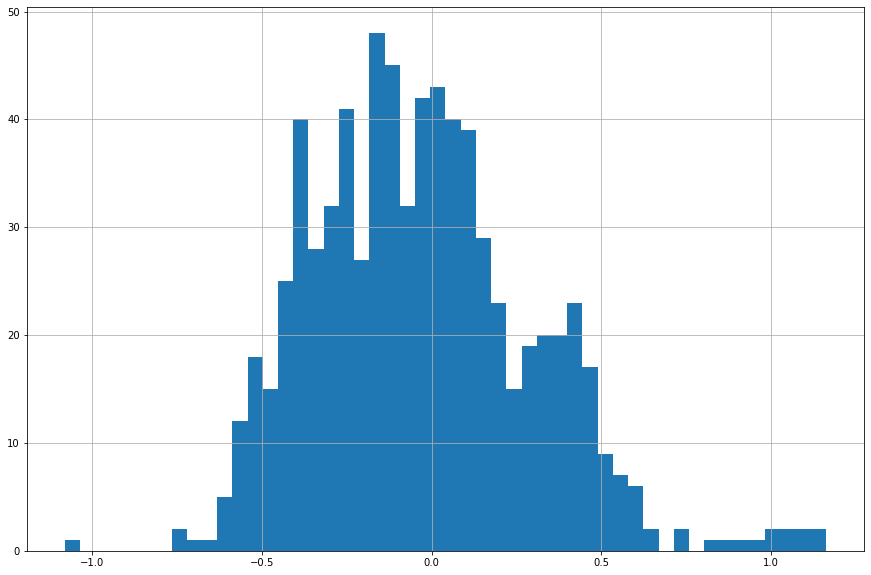

In [ ]:

DeltaGs['dG'].hist(bins=50, figsize=(15, 10))  # Adjust the number of bins and figure size as needed


### Optimize the XGBoost hyperparameters

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

# Splitting the dataset into training and validation sets
target = DeltaGs.loc[:,"dG"]
X_train, X_valid, y_train, y_valid = train_test_split(df_index, target, random_state=42, test_size=0.20)

def objective(trial):
    # Define the hyperparameters to be tuned
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.1, 1.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    # Create and fit the model
    model = xgb.XGBRegressor(**param, early_stopping_rounds=50)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

    # Predict and calculate the error
    preds = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, preds, squared=False)

    return rmse

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Best hyperparameters
best_params = study.best_params
print('Best parameters:', best_params)

[I 2024-05-06 13:34:50,724] A new study created in memory with name: no-name-aadec776-60fd-4c22-a1be-28a907f7f2ba
/home/ABTLUS/james.almeida/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-06 13:35:08,033] Trial 0 finished with value: 0.2825110505822743 and parameters: {'n_estimators': 297, 'max_depth': 11, 'min_child_weight': 2, 'gamma': 0.37998043564824113, 'learning_rate': 0.24400549493724194, 'subsample': 0.7503252318669078, 'colsample_bytree': 0.8418998088944358}. Best is trial 0 with value: 0.2825110505822743.
/home/ABTLUS/james.almeida/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squar

/home/ABTLUS/james.almeida/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-06 13:43:57,219] Trial 13 finished with value: 0.2850971667818685 and parameters: {'n_estimators': 145, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 0.1367367880699944, 'learning_rate': 0.10734772583173108, 'subsample': 0.581332745432164, 'colsample_bytree': 0.6370687501431884}. Best is trial 7 with value: 0.2682234586208839.
/home/ABTLUS/james.almeida/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-06 13:44:42,860] Trial 14 finished with value: 0.27733196583919006 and parame

/home/ABTLUS/james.almeida/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-06 13:52:15,237] Trial 27 finished with value: 0.27882061801322083 and parameters: {'n_estimators': 193, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 0.1284556854950292, 'learning_rate': 0.1252329344229833, 'subsample': 0.6465111633438552, 'colsample_bytree': 0.6142154257657058}. Best is trial 7 with value: 0.2682234586208839.
/home/ABTLUS/james.almeida/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-06 13:52:49,987] Trial 28 finished with value: 0.27617054670325264 and para

/home/ABTLUS/james.almeida/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-06 13:58:59,726] Trial 41 finished with value: 0.26971276740156314 and parameters: {'n_estimators': 273, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.301307316983062, 'learning_rate': 0.05408116383285786, 'subsample': 0.644332576847926, 'colsample_bytree': 0.7484010157542207}. Best is trial 7 with value: 0.2682234586208839.
/home/ABTLUS/james.almeida/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-06 13:59:45,784] Trial 42 finished with value: 0.27470230672942275 and param

### Perform the train/test split

In [ ]:
from sklearn.model_selection import train_test_split

target = DeltaGs.loc[:,"dG"]
xtrain, xtest, ytrain, ytest = train_test_split(df_index, target, random_state=42, test_size=0.20)

### Train the XGBoost method

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

xgbr = xgb.XGBRegressor(**best_params)
'''                        tree_method="hist",
                        n_estimators = 1000,
                        learning_rate = 0.09,
                        gamma = 1,
                        subsample=0.1,
                        colsample_bytree = 0.4,
                        max_depth = 5,
                        enable_categorical=False,
                        njobs=4)
'''
xgbr.fit(xtrain, ytrain)

y_pred = xgbr.predict(xtest)
y_pred_train = xgbr.predict(xtrain)

In [ ]:
mae_test=mean_absolute_error(ytest, y_pred)
mae_train=mean_absolute_error(ytrain, y_pred_train)
RMSE = mean_squared_error(ytest, y_pred, squared=False)
RMSE_train = mean_squared_error(ytrain, y_pred_train, squared=False)
print("MAE test =", mae_test, 'eV', "MAE train =", mae_train, 'eV')
print("RMSE test =", RMSE, 'eV', "RMSE train =", RMSE_train, 'eV')

MAE test = 0.20234988377351715 eV MAE train = 0.06008965542588373 eV
RMSE test = 0.26441984931811996 eV RMSE train = 0.08221473495534125 eV


### Plot the test/train data comparing to the ideal line.

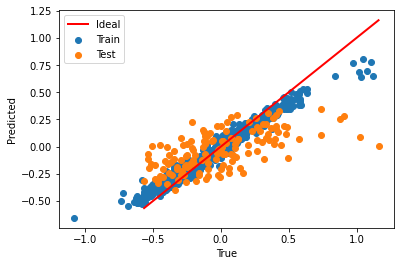

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(ytrain,y_pred_train, label='Train')
plt.scatter(ytest,y_pred, label='Test')
# Plot the 45-degree line (line with angular coefficient of 1)
x_line = np.linspace(min(ytest), max(ytest), 100)
plt.plot(x_line, x_line, color='red', linestyle='-', linewidth=2, label='Ideal')

plt.xlabel('True')
plt.ylabel('Predicted')
plt.legend()

plt.show()

<font color='red' size='5'>
The optimized model overfitted a bit, needs to investigate why
</font>

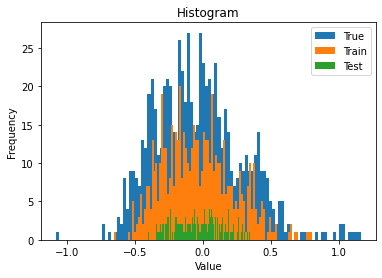

In [ ]:
#DeltaGs['dG'].hist(bins=50, figsize=(15, 10))  # Adjust the number of bins and figure size as needed
#y_pred_train.hist(bins=50, figsize=(15, 10))  # Adjust the number of bins and figure size as needed
#y_pred.hist(bins=50, figsize=(15, 10))  # Adjust the number of bins and figure size as needed

plt.hist(DeltaGs['dG'].values, bins=100, label='True')  # 'bins' defines the number of intervals or 'buckets'
plt.hist(y_pred_train, bins=100, label='Train')  # 'bins' defines the number of intervals or 'buckets'
plt.hist(y_pred, bins=100, label='Test')  # 'bins' defines the number of intervals or 'buckets'
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
        n_estimators=100,
        max_leaf_nodes=None,
        max_depth=30,
        n_jobs=8,
        max_features='sqrt'
    )

model.fit(xtrain, ytrain)

y_true = ytest
y_pred = model.predict(xtest)
y_pred_train = model.predict(xtrain)

RMSE = mean_squared_error(y_true, y_pred, squared=False)
RMSE_train = mean_squared_error(ytrain, y_pred_train, squared=False)
mae_test=mean_absolute_error(ytest, y_pred)
mae_train=mean_absolute_error(ytrain, y_pred_train)

print("MAE test =", mae_test, "MAE train =", mae_train)
print(f"RMSE test {RMSE} eV.", f"RMSE train {RMSE_train} eV.")

# Plot the scatter plot
plt.scatter(ytrain, y_pred_train, label='Train')
plt.scatter(y_true, y_pred, label='Test')

# Plot the 45-degree line (line with angular coefficient of 1)
x_line = np.linspace(min(y_true), max(y_true), 100)
plt.plot(x_line, x_line, color='red', linestyle='-', linewidth=2, label='Ideal')

plt.xlabel('True')
plt.ylabel('Predicted')
plt.legend()
plt.show()

### Neural Network

In [ ]:
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import MinMaxScaler

normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(xtrain)
normalizador_y.fit(ytrain.values.reshape(-1, 1))
normalizador_x.fit(xtest)
normalizador_y.fit(ytest.values.reshape(-1, 1))
#xtrain = xtrain.values.ravel()
#ytrain = ytrain.values.ravel()
#xtest = xtest.values.ravel()
#ytest = ytest.values.ravel()

print(len(xtrain.keys()))
model = MLPRegressor(hidden_layer_sizes=(200,200,200), max_iter=1000)
model.fit(xtrain, ytrain)

y_true = ytest
y_pred = model.predict(xtest)
y_pred_train = model.predict(xtrain)

RMSE = mean_squared_error(y_true, y_pred, squared=False)
RMSE_train = mean_squared_error(ytrain, y_pred_train, squared=False)
mae_test=mean_absolute_error(ytest, y_pred)
mae_train=mean_absolute_error(ytrain, y_pred_train)

print("MAE test =", mae_test, "MAE train =", mae_train)
print(f"RMSE test {RMSE} eV.", f"RMSE train {RMSE_train} eV.")

# Plot the scatter plot
plt.scatter(ytrain, y_pred_train, label='Train')
plt.scatter(y_true, y_pred, label='Test')

# Plot the 45-degree line (line with angular coefficient of 1)
x_line = np.linspace(min(y_true), max(y_true), 100)
plt.plot(x_line, x_line, color='red', linestyle='-', linewidth=2, label='Ideal')

plt.xlabel('True')
plt.ylabel('Predicted')
plt.legend()
plt.show()

In [ ]:
plt.hist(DeltaGs['dG'].values, bins=100, label='True')  # 'bins' defines the number of intervals or 'buckets'
plt.hist(y_pred_train, bins=100, label='Train')  # 'bins' defines the number of intervals or 'buckets'
plt.hist(y_pred, bins=100, label='Test')  # 'bins' defines the number of intervals or 'buckets'
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Inference Section

### Let's generate the nanoparticles for inference.

In [ ]:
species = ['Pd', 'Pt', 'Ag', 'Cu', 'Au']

In [ ]:
import random
from ase import Atoms

all_inference_structures = list()
coordinates = original_coordinates
num_atm = 55

for i in range(0,100000):
    np_species = list()
    for atm in range(num_atm):
        np_species.append(random.choice(species))
    np_species.append('H')
    #print(len(np_species))
    #print(np_species)
    inference_structure = Atoms(np_species, positions=coordinates)
    all_inference_structures.append(inference_structure)

<font color='red' size='5'>
Tryed 1 million structures, but memory exploded when SOAPfying. 100 thousand should be enough.
</font>

In [ ]:
species_soap = species + ['H']
print(species_soap)

feature_vectors = soap.create(all_inference_structures, n_jobs=4)

print("Feature Vector", len(feature_vectors))
print(type(feature_vectors))
print('Number of features', soap.get_number_of_features())
#soap_features = pd.DataFrame(feature_vectors)

['Pd', 'Pt', 'Ag', 'Cu', 'Au', 'H']
Feature Vector 100000
<class 'numpy.ndarray'>
Number of features 10584


In [ ]:
predictions = xgbr.predict(feature_vectors)

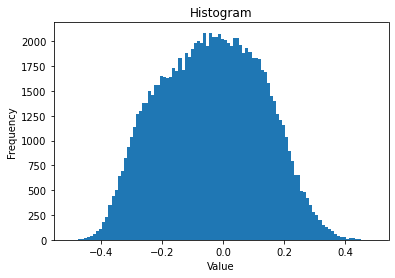

In [ ]:
plt.hist(predictions, bins=100)  # 'bins' defines the number of intervals or 'buckets'
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [ ]:
filtered_indices_zero = np.where((predictions > -0.0001) & (predictions < 0.0001))[0]
print("Number of filtered elements close to zero:", len(filtered_indices_zero))
print("Filtered indices close to zero:", filtered_indices_zero)

filtered_indices_low = np.where((predictions < -0.45))[0]
print("Number of filtered elements low:", len(filtered_indices_low))
print("Filtered indices low:", filtered_indices_low)

filtered_indices_high = np.where((predictions > 0.425))[0]
print("Number of filtered elements high:", len(filtered_indices_high))
print("Filtered indices high:", filtered_indices_high)


Number of filtered elements close to zero: 40
Filtered indices close to zero: [  606  2169  5509  6257 11854 15712 20755 23656 29174 33429 35367 36054
 42231 44584 48788 49998 50014 54264 54424 58726 62608 62794 63533 64948
 65979 66046 66505 69192 73008 77075 78902 79985 84753 85442 90919 91114
 96707 96759 96994 97598]
Number of filtered elements low: 24
Filtered indices low: [ 2223  7610  7804 14848 24123 26457 53097 55577 59112 59883 60454 61661
 62914 68961 70260 70618 75464 77249 77302 79161 81671 86812 94506 98721]
Number of filtered elements high: 27
Filtered indices high: [  293  3876  5859 20258 25507 31053 35138 35347 35862 40455 44545 47689
 49695 50231 54856 58851 62985 63360 67094 74195 75477 77113 84834 88023
 90135 90205 98196]


In [ ]:
for index in filtered_indices_zero:
    filename = f'Suggestions_run1/structure_suggestion_zero{index:06}.xyz'
    atom_structure = all_inference_structures[index]

    # Get existing coordinates
    coordinates = atom_structure.get_positions()

    # Get and append the symbol
    symbols = atom_structure.get_chemical_symbols()

    with open(filename, 'w') as file:
        file.write(str(len(symbols)) + '\n')  # Writing the updated atom count
        file.write('Predicted dG: ' + str(predictions[index]) + '\n')

        for symbol, coordinate in zip(symbols, coordinates):
            file.write(f'{symbol} {coordinate[0]} {coordinate[1]} {coordinate[2]}\n')


In [ ]:
for index in filtered_indices_low:
    filename = f'Suggestions_run1/structure_suggestion_low{index:06}.xyz'
    atom_structure = all_inference_structures[index]

    # Get existing coordinates
    coordinates = atom_structure.get_positions()

    # Get and append the symbol
    symbols = atom_structure.get_chemical_symbols()

    with open(filename, 'w') as file:
        file.write(str(len(symbols)) + '\n')  # Writing the updated atom count
        file.write('Predicted dG: ' + str(predictions[index]) + '\n')

        for symbol, coordinate in zip(symbols, coordinates):
            file.write(f'{symbol} {coordinate[0]} {coordinate[1]} {coordinate[2]}\n')


In [ ]:
for index in filtered_indices_high:
    filename = f'Suggestions_run1/structure_suggestion_high{index:06}.xyz'
    atom_structure = all_inference_structures[index]

    # Get existing coordinates
    coordinates = atom_structure.get_positions()

    # Get and append the symbol
    symbols = atom_structure.get_chemical_symbols()

    with open(filename, 'w') as file:
        file.write(str(len(symbols)) + '\n')  # Writing the updated atom count
        file.write('Predicted dG: ' + str(predictions[index]) + '\n')

        for symbol, coordinate in zip(symbols, coordinates):
            file.write(f'{symbol} {coordinate[0]} {coordinate[1]} {coordinate[2]}\n')
